### Hourly Forecast - Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
train = pd.read_csv('train_bike.csv')
test = pd.read_csv('test_bike.csv')

## Data Summary

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
weather - 1 = Clear, Few clouds, Partly cloudy <br>
2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
casual - number of non-registered user rentals initiated <br>
registered - number of registered user rentals initiated <br>
count - number of total rentals

In [3]:
train.shape, test.shape

((12980, 12), (4399, 11))

In [4]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
12975,2012-06-29 20:00:00,3,0,1,1,37.72,44.695,42.0,16.9979,53,255,308
12976,2012-06-29 21:00:00,3,0,1,2,35.26,41.665,53.0,12.9980,41,195,236
12977,2012-06-29 22:00:00,3,0,1,3,33.62,41.665,63.0,12.9980,34,129,163
12978,2012-06-29 23:00:00,3,0,1,3,33.62,41.665,63.0,12.9980,6,42,48
12979,2012-06-30 0:00:00,3,0,0,3,26.24,28.790,89.0,11.0014,4,65,69


In [5]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [6]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

'count' is the target variable. Factors on which 'count' might depend: registered, time, holiday, workingday, weather. 

In [7]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

All the vars in the dataset except 'datetime' are numerical/continuous (int, float). 'datetime' is categorical var. 

This is a regression problem as the target var i.e. 'count' is countinuous numeric. 

<Axes: >

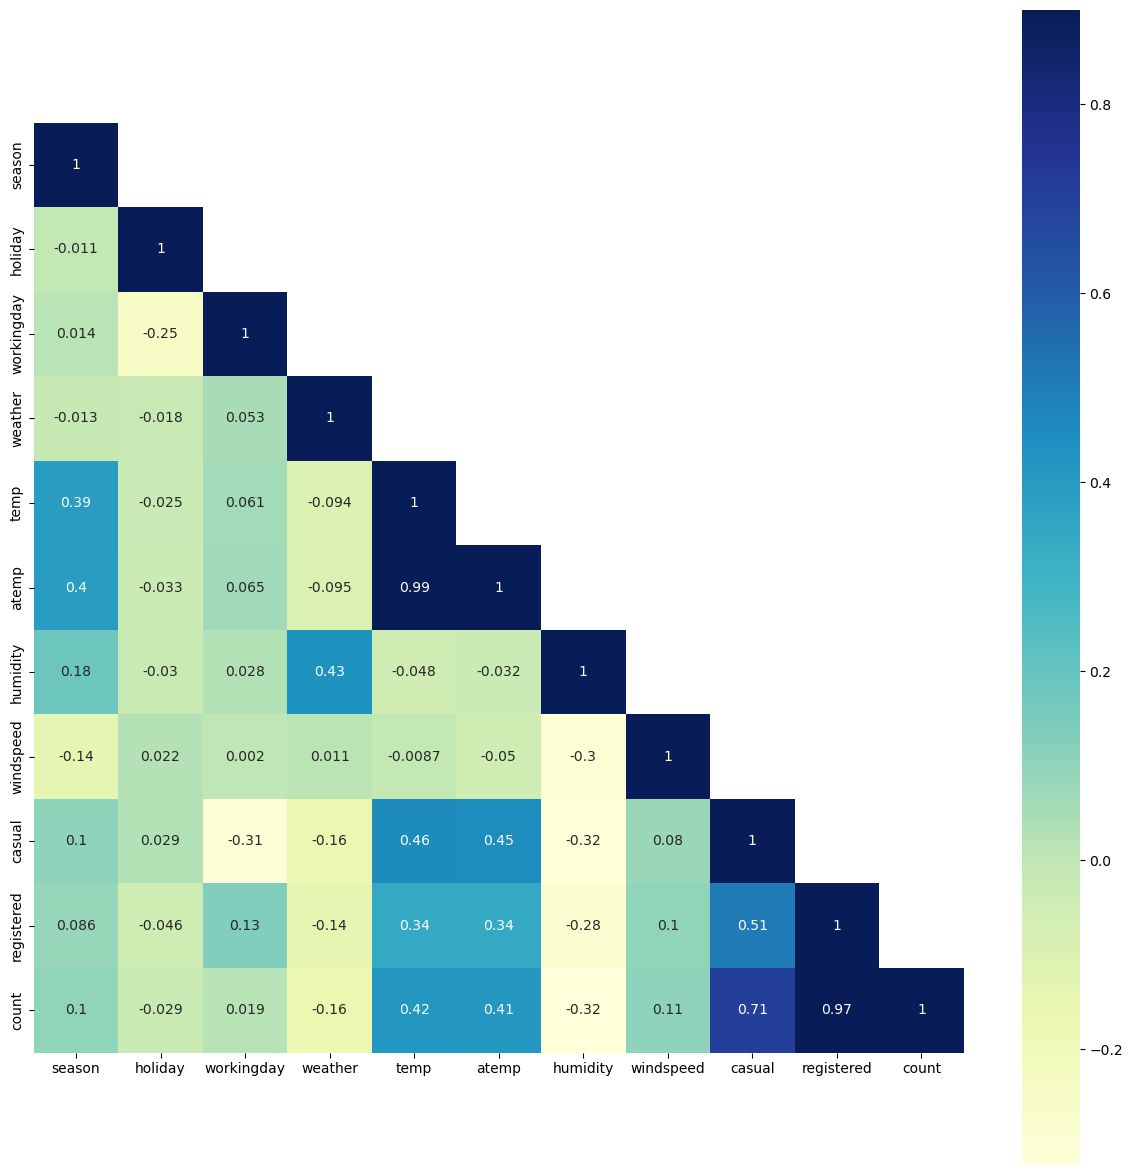

In [8]:
corr = train.corr(numeric_only=True)
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True, cmap="YlGnBu")

1. 'atemp' and 'temp' are highly correlated with each other & highly affect the 'count'-> during model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data. <br>
2. 'humidity' & 'count' are inversely related -> people are not likely to travel on a bike in a humid weather. <br>
3. 'weather' & 'count' are inversely related because as weather is increasing from (1 to 4), it's getting worse and so fewer people will rent bikes. <br>
4. 'holiday' & 'count' are inversely related. <br>
5. 'registered' & 'count' are highly correlated -> most bikes are rented to registered users. <br>

## Feature Engineering/ Extraction

Convert the date in datetime format -> extract the hour & month from the 'datetime' variable. Make similar changes on both train & test data.

In [9]:
# to_datetime() is used to convert a date with string datatype to datetime datatype
dt_train = pd.to_datetime(train.datetime).dt
train['month'] = dt_train.month
train['hour'] = dt_train.hour

dt_test = pd.to_datetime(test.datetime).dt
test['month'] = dt_test.month
test['hour'] = dt_test.hour

In [10]:
season=pd.get_dummies(train['season'],prefix='season')
train=pd.concat([train,season],axis=1)
season=pd.get_dummies(test['season'],prefix='season')
test=pd.concat([test,season],axis=1)

In [11]:
weather=pd.get_dummies(train['weather'],prefix='weather')
train=pd.concat([train,weather],axis=1)
weather=pd.get_dummies(test['weather'],prefix='weather')
test=pd.concat([test,weather],axis=1)

In [12]:
train.drop(['season','weather','datetime','atemp',
           'registered','casual'],inplace=True,axis=1)
test.drop(['season','weather','datetime','atemp',
           'registered','casual'],inplace=True,axis=1)

'registered' & 'casual' are leakage variables, so they need to be dropped. Data Leakage occurs when the data used in the training process contains info about what the model is trying to predict. Giveaway features are those that expose the info about the target var and would not be available after the model is deployed.

## Missing Value Treatment

<Axes: >

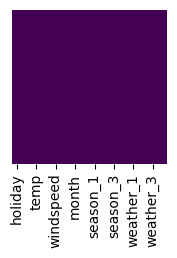

In [13]:
plt.figure(figsize=(2,2))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
train.isnull().sum()

holiday       0
workingday    0
temp          0
humidity      0
windspeed     0
count         0
month         0
hour          0
season_1      0
season_2      0
season_3      0
season_4      0
weather_1     0
weather_2     0
weather_3     0
weather_4     0
dtype: int64

In [15]:
test.isnull().sum()

holiday       0
workingday    0
temp          0
humidity      0
windspeed     0
month         0
hour          0
season_1      0
season_3      0
season_4      0
weather_1     0
weather_2     0
weather_3     0
dtype: int64

No missing values in train & test data sets.

Since test set does not contain 'count','season_2' & 'weather_4' as features -> these 2 features should be dropped from the train dataset as well before model building.

## Outlier Treatment

<Axes: xlabel='count'>

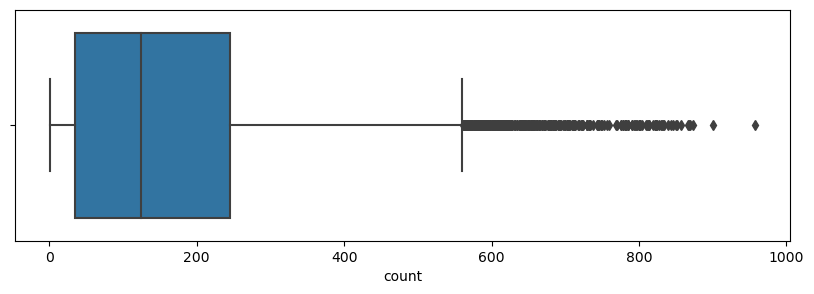

In [16]:
plt.figure(figsize=(10,3))
sns.boxplot(data=train, x='count')

In [17]:
train.loc[train['count']>700,'count'] = np.median(train['count'])

## Univariate Analysis

<Axes: >

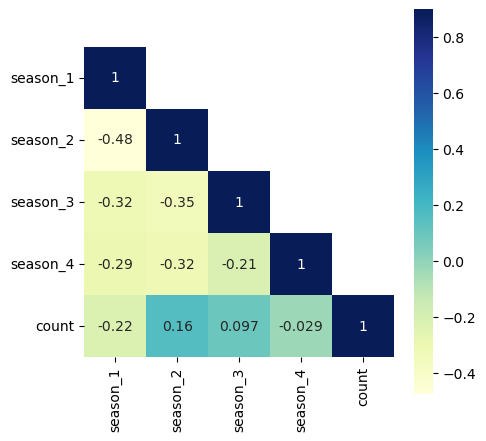

In [18]:
corr = train[['season_1','season_2','season_3','season_4','count']].corr(numeric_only=True)
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True, cmap="YlGnBu")

People are more likely to rent a bike during summer & fall. 

In [19]:
train.describe()

,holiday,workingday,temp,humidity,windspeed,count,month,hour,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000
mean,0.027504,0.685978,19.725422,62.358552,13.141760,162.666256,5.543914,11.554545,0.306626,0.339676,0.189291,0.164407,0.660709,0.252157,0.086903,0.000231
std,0.163553,0.464143,7.828902,19.963696,8.325987,151.757026,3.303415,6.911950,0.461110,0.473618,0.391755,0.370659,0.473487,0.434268,0.281704,0.015202
min,0.000000,0.000000,0.820000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.120000,47.000000,7.001500,35.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,19.680000,62.000000,12.998000,124.000000,5.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.240000,79.000000,19.001200,240.000000,8.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,40.180000,100.000000,56.996900,700.000000,12.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


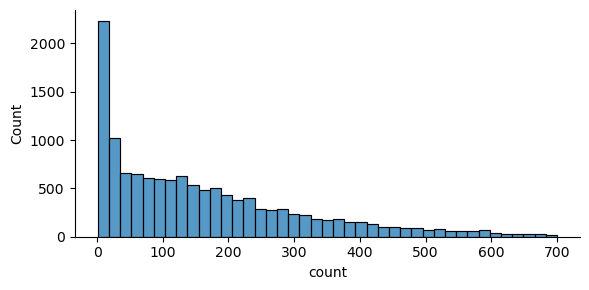

In [20]:
sns.displot(train['count'], height=3, aspect=2)

We can infer that the distribution of 'count' variable is right skewed. Most of the ML techniques require the dependent var to have a normal distribution. let's take cube root of the variable. 

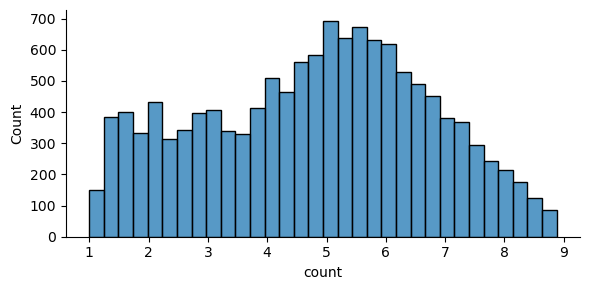

In [21]:
sns.displot(np.power(train['count'],1/3), height=3, aspect=2)

Now, the distribution is normal.

## Bivariate Analysis

<Axes: xlabel='hour', ylabel='count'>

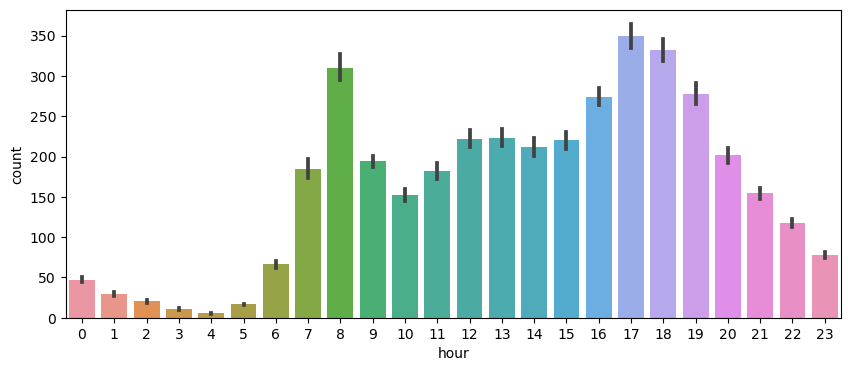

In [22]:
plt.figure(figsize=(10,4))
sns.barplot(x="hour",y="count",data=train)

Demand is high between 7am-9am & 12pm-8pm  

<Axes: xlabel='month', ylabel='count'>

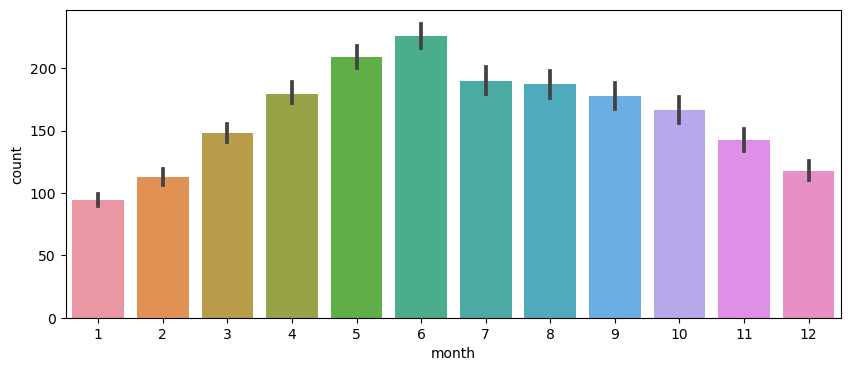

In [23]:
plt.figure(figsize=(10,4))
sns.barplot(x="month",y="count",data=train)

High demand from March to November.

<Axes: xlabel='temp', ylabel='count'>

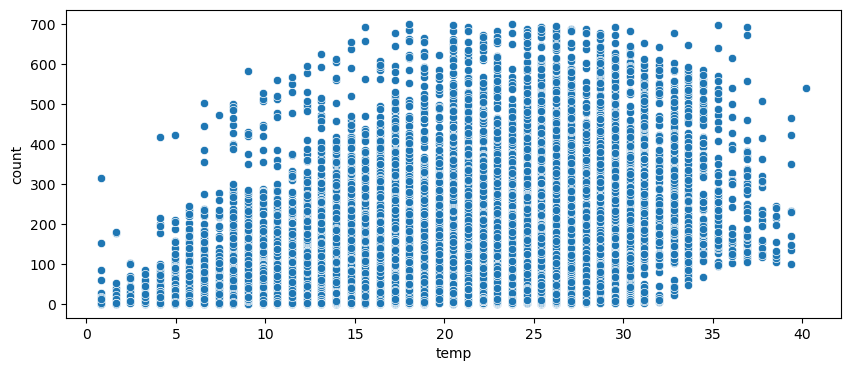

In [24]:
plt.figure(figsize=(10,4))
sns.scatterplot(x="temp",y="count",data=train)

Convert 'temp' variable into bins & treat it like a discrete variable for better visualization.

In [25]:
new_train=train.copy()

<Axes: xlabel='temp_bin', ylabel='count'>

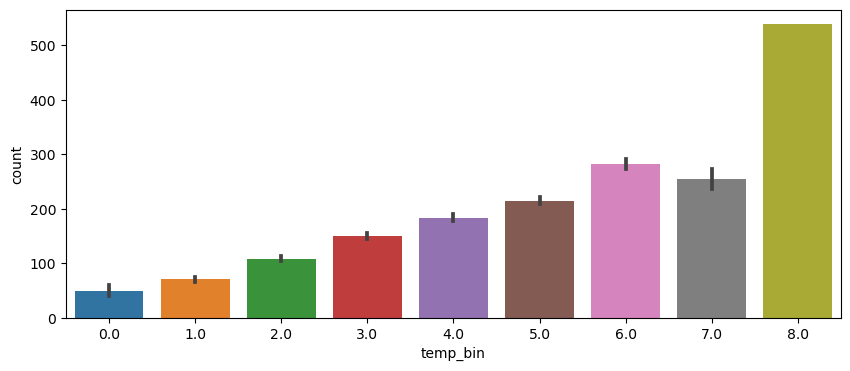

In [26]:
new_train['temp_bin']=np.floor(new_train['temp'])//5
new_train['temp_bin'].unique()
plt.figure(figsize=(10,4))
sns.barplot(x="temp_bin",y="count",data=new_train)

High demand when temperature is btw 30-40 degree celsius.

## Model Building

In [27]:
train.drop(['season_2','weather_4'], inplace=True, axis=1)

In [28]:
# 'count' variable transformation
target = np.power(train['count'],1/3)
train = train.drop('count', axis=1)
x_train,x_val,y_train,y_val = train_test_split(train, target,test_size=0.2,random_state=42)

In [29]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((10384, 13), (10384,), (2596, 13), (2596,))

In [30]:
from sklearn.metrics import mean_squared_log_error as MSLE

## Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [32]:
dt_reg = DTR(max_depth=9, min_samples_leaf=14).fit(x_train, y_train)
y_pred = dt_reg.predict(x_val)
rmsle = MSLE(y_val, y_pred, squared=False)

In [33]:
rmsle

0.1269719399279189

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [35]:
rfr_reg = RFR(n_estimators=500).fit(x_train, y_train)
y_pred_rfr = rfr_reg.predict(x_val)
rmsle_rfr = MSLE(y_val, y_pred_rfr, squared=False)

In [36]:
rmsle_rfr

0.11244164665623578

Random Forest Regressor performs best on validation set. 

In [38]:
test_pred = rfr_reg.predict(test)
final_pred = np.power(test_pred,3)

In [40]:
submission = pd.DataFrame()
submission['count'] = final_pred
submission.to_csv('submission_bike.csv', header=True, index=False)